In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import shapiro
from scipy.stats import normaltest


## Загрузка и подготовка данных

### Формирование общего датафрейма

In [3]:
# Создаем пустой список для хранения датафреймов
datasets = []

# Указываем путь к директории, содержащей наши CSV файлы
directory = 'data'

# Прочитаем каждый CSV файл и добавим его в список датафреймов
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        datasets.append(df)

# Объединяем все датафреймы в один, игнорируя индексы и используя внешнее объединение
df = pd.concat(datasets, ignore_index=True, join='outer')

# Извлекаем год из столбца tourney_id и преобразуем его в целочисленный тип
df['year'] = df['tourney_id'].str.extract(r'(\d{4})').astype(int)

# Сохраняем объединенный датафрейм в файл 'full_data/combined_atp_matches.csv' без индексов
df.to_csv('data/all_atp.csv', index=False)

In [12]:
df = pd.read_csv('data/all_atp.csv')
df.shape

(191920, 50)

In [63]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1999-339,Adelaide,Hard,32.0,A,19990104,1,102158,Patrick Rafter,R,...,14.0,4.0,7.0,3.0,7.0,4.0,3315.0,115.0,415.0,1999
1,1999-339,Adelaide,Hard,32.0,A,19990104,2,101792,Slava Dosedel,R,...,31.0,12.0,11.0,5.0,8.0,64.0,723.0,77.0,635.0,1999
2,1999-339,Adelaide,Hard,32.0,A,19990104,3,102562,Jiri Novak,R,...,12.0,8.0,8.0,3.0,8.0,75.0,669.0,59.0,757.0,1999
3,1999-339,Adelaide,Hard,32.0,A,19990104,4,103720,Lleyton Hewitt,R,...,30.0,17.0,11.0,8.0,10.0,100.0,482.0,35.0,1007.0,1999
4,1999-339,Adelaide,Hard,32.0,A,19990104,5,101727,Jason Stoltenberg,R,...,16.0,13.0,8.0,4.0,7.0,27.0,1280.0,81.0,613.0,1999


### Проверяем пропуски

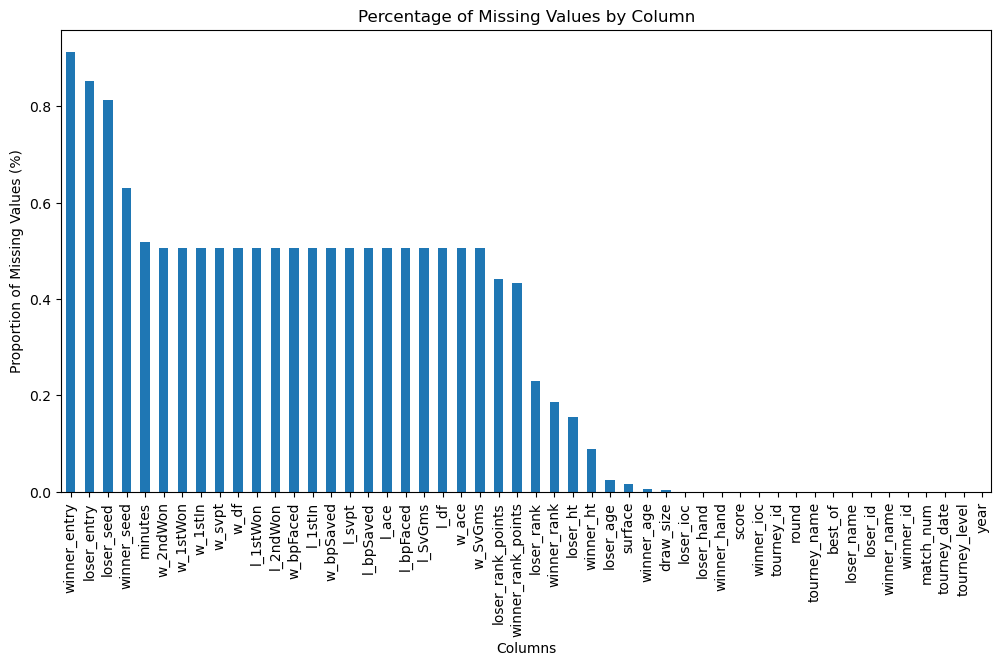

In [3]:
# Вычисляем процент пропущенных значений
percent_missing = df.isnull().mean().sort_values(ascending=False)

# Создаем тепловую карту отсортированных данных
percent_missing.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Proportion of Missing Values (%)')
plt.xlabel('Columns')
plt.title('Percentage of Missing Values by Column')
plt.show()

В таких ячейках как: 'winner_entry', 'loser_entry', 'loser_seed' процент пропусков составляет более 60%. А значит они не будут статистически значимы и их можно удалить

In [14]:
# удаляем столбцы с пропусками более 60%
df = df.dropna(axis=1, thresh=(0.4 * df.shape[0]))


## Задание 1

 a) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);


У нас есть две гипотезы:

$H_0$: вероятность выигрыша не зависит от ранга игрока

$H_a$: если ранг игрока выше, чем ранг соперника более чем на 20 позиций, то в среднем вероятность выиграть у него больше



1) Сформируем 2 выборки: 

- игроки с рангом, отличающимся более чем на 20 позиций от противника,

- игроки с близким рангом к противнику (отличие менее 20 позиций)




In [64]:
df_rank_1 = df[['winner_id', 'loser_id', 'winner_rank', 'loser_rank']].dropna()
df_rank_1['higher_rank_win'] = abs((df_rank_1['winner_rank'] - df_rank_1['loser_rank'])) > 20

In [65]:
df_rank_1['higher_rank_win'].value_counts()

higher_rank_win
True     106767
False     37093
Name: count, dtype: int64

2) Для каждой игры в выборках посчитать ожидаемое количество побед при случайном исходе. Это можно сделать, умножив количество сыгранных игр на вероятность выигрыша 0,5 (при равных шансах для каждого игрока).

3) Посчитать фактическое количество побед для каждого игрока в выборках.

4) Вычислить отклонение фактического количества побед от ожидаемого для каждого игрока.

In [75]:
def player_metrics(df_rank_1):
    """
    Функция для расчета:
    - ожидаемого количества побед при случайном исходе, 
    - фактического количества побед для каждого игрока,
    - отклонения фактического количества побед от ожидадаемого для каждого игрока.

    """
    wins_count = df_rank_1['winner_id'].value_counts().astype(int).rename('wins')
    losses_count = df_rank_1['loser_id'].value_counts().astype(int).rename('losses')
    total_games = wins_count.add(losses_count, fill_value=0).astype(int).rename('total')
    player_performance_df = pd.concat([wins_count, losses_count, total_games], axis=1).reset_index().rename(columns={'index': 'player_id'})
    player_performance_df['expected_wins'] = player_performance_df['total'] * 0.5
    player_performance_df['deviation'] = player_performance_df['wins'] - player_performance_df['expected_wins']
    return player_performance_df.sort_values(by='total', ascending=False)

In [76]:
more20 = player_metrics(df_rank_1[df_rank_1['higher_rank_win'] == True])
less20 = player_metrics(df_rank_1[df_rank_1['higher_rank_win'] == False])

In [77]:
more20.head()

,player_id,wins,losses,total,expected_wins,deviation
0,103819,821.0,103.0,924,462.0,359.0
1,104745,694.0,88.0,782,391.0,303.0
4,101736,614.0,132.0,746,373.0,241.0
2,104925,661.0,73.0,734,367.0,294.0
3,100656,626.0,86.0,712,356.0,270.0


In [78]:
less20.head()

,player_id,wins,losses,total,expected_wins,deviation
0,103819,441.0,177.0,618,309.0,132.0
1,104925,437.0,141.0,578,289.0,148.0
2,104745,385.0,139.0,524,262.0,123.0
3,100656,325.0,145.0,470,235.0,90.0
4,100284,277.0,138.0,415,207.5,69.5


5. Рассчитать среднее отклонение для каждой выборки.

6. Сравнить средние отклонения между выборками.

In [70]:
# Рассчитаем среднее отклонение для каждой выборки
mean_dev_more20 = more20.deviation.abs().mean()
mean_dev_less20 = less20.deviation.abs().mean()

print(f'Cреднее отклонение для выборки more20: {round(mean_dev_more20, 2)}')
print(f'Cреднее отклонение для выборки less20: {round(mean_dev_less20, 2)}')


Cреднее отклонение для выборки more20: 7.23
Cреднее отклонение для выборки less20: 2.97


/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


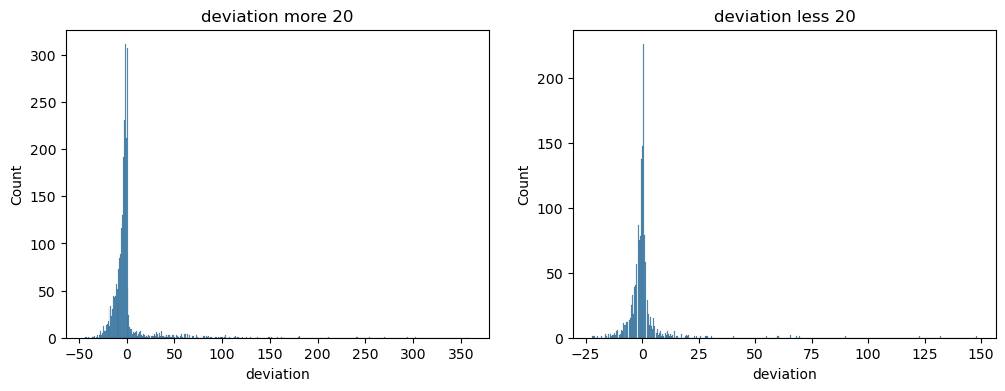

In [117]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='deviation', data=more20, ax=axes[0])
sns.histplot(x='deviation', data=less20, ax=axes[1])
#задаём названия графикам
axes[0].set_title('deviation more 20');
axes[1].set_title('deviation less 20');

## <u>*Вывод 1 для задания 1_а:*</u> 

В первой выборке (ранг выше более чем на 20 позиций) среднее отклонение значительно выше, чем во второй выборке, то это подтверждает гипотезу о большей вероятности выигрыша у игроков с более высоким рангом.

Но давайте проведем статистические тесты:

1. Проверка данных на нормальность:

- Тест Шапиро-Уилка

In [124]:
def shapiro_test(df1, df2, alpha=0.05):
    """
    Функция для проверки нормальности распределения в двух выборках с помощью критерия Шапиро-Уилка
    """
    H0 = 'Распределения в обеих группах нормальные'
    H1 = 'Распределение в одной или обеих группах отлично от нормального'

    # вычисляем результат теста Шапиро-Уилка для выборок
    shapiro_result_a = shapiro(df1)
    shapiro_result_b = shapiro(df2)
    print(f'alpha: {alpha}')
    print('p-value группы А', round(shapiro_result_a.pvalue, 3))
    print('p-value группы B', round(shapiro_result_b.pvalue, 3))
    # сравниваем полученное p-value с уровнем значимости
    if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
        print("Отвергаем нулевую гипотезу. {}".format(H0))
        print("Альтернативная гипотеза. H1: {}".format(H1))
    else:
        print("Принимаем нулевую гипотезу. {}".format(H0))

In [125]:
shapiro_test(more20['deviation'], less20['deviation'])

alpha: 0.05
p-value группы А 1.0
p-value группы B 1.0
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


- Тест Д'Агостино

In [126]:
def test_normality(data, alpha=0.05):
    """
    Функция для проверки нормальности распределения данных
    """
    _, p = normaltest(data)
    print('p=%.3f' % (p))
    
    if p > alpha:
        print('Данные распределены нормально')
    else:
        print('Данные не распределены нормально')

In [127]:
test_normality(more20.deviation.dropna())
test_normality(less20.deviation.dropna())

p=0.000
Данные не распределены нормально
p=0.000
Данные не распределены нормально
